In [1]:
import os
import datasets
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer
os.environ["WANDB_DISABLED"] = "true"

/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

### **Initialize VisionEncoderDecoderModel**

In [3]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.crossattention.q_attn.weight', 'h.9.crossattention.c_attn.bias', 'h.2.crossattention.c_proj.bias', 'h.10.ln_cross_attn.weight', 'h.5.crossattention.q_attn.bias', 'h.8.crossattention.q_attn.bias', 'h.10.crossattention.c_proj.bias', 'h.8.crossattention.q_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.5.crossattention.c_attn.bias', 'h.2.crossattention.c_attn.bias', 'h.3.crossattention.c_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.bias', 'h.8.ln_cross_attn.weight', 'h.5.crossattention.q_attn.weight', 'h.3.ln_cross_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.4.ln_cross_attn.bias', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.q_attn.bias', 'h.9.ln_cross_attn.bias', 'h.8.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.4.crossattention.q_attn.bias', 'h.5.crossattent

In [4]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [6]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [7]:
import datasets
ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="./dummy_data/")

Extracting data files: 100%|██████████| 5/5 [00:00<00:00, 206.78it/s]


Dataset coco_dataset_script downloaded and prepared to /home/vcl3d/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-data_dir=dummy_data/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 57.09it/s]


In [8]:
# print single example
ds['train'][0]

{'image_id': 74,
 'caption_id': 145996,
 'caption': 'A picture of a dog laying on the ground.',
 'height': 426,
 'width': 640,
 'file_name': '000000000074.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000000074.jpg',
 'image_path': '/home/vcl3d/.cache/huggingface/datasets/downloads/extracted/b0e2c65626bfdbc9674e1420d9c5d31d0f60601828e383a8ec59182ceafe3238/train2017/000000000074.jpg'}

In [9]:
from PIL import Image

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions,
                      padding="max_length",
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image_path']
    captions = examples['caption']

    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [10]:
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

In [11]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 80
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 16
    })
})

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
    num_train_epochs= 15
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
import evaluate
metric = evaluate.load("rouge")

In [15]:
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [16]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

In [17]:
trainer.train()

/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/150 [00:00<?, ?it/s]/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  7%|▋         | 10/150 [00:11<01:55,  1.21it/s]/data1/ViTgpt2/gpt2env/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation con

{'eval_loss': 0.3528639078140259, 'eval_rouge1': 15.2741, 'eval_rouge2': 0.7039, 'eval_rougeL': 14.6471, 'eval_rougeLsum': 14.7014, 'eval_gen_len': 16.5625, 'eval_runtime': 10.4175, 'eval_samples_per_second': 7.679, 'eval_steps_per_second': 0.96, 'epoch': 1.0}


 13%|█▎        | 20/150 [00:38<01:55,  1.12it/s]

{'eval_loss': 0.3339892625808716, 'eval_rouge1': 20.1108, 'eval_rouge2': 3.0575, 'eval_rougeL': 18.4547, 'eval_rougeLsum': 18.5671, 'eval_gen_len': 13.875, 'eval_runtime': 8.3148, 'eval_samples_per_second': 9.621, 'eval_steps_per_second': 1.203, 'epoch': 2.0}


 20%|██        | 30/150 [00:54<01:43,  1.15it/s]

{'eval_loss': 0.3291168808937073, 'eval_rouge1': 22.4796, 'eval_rouge2': 4.4731, 'eval_rougeL': 20.3732, 'eval_rougeLsum': 20.5252, 'eval_gen_len': 14.0, 'eval_runtime': 8.7255, 'eval_samples_per_second': 9.168, 'eval_steps_per_second': 1.146, 'epoch': 3.0}


 27%|██▋       | 40/150 [01:10<01:35,  1.15it/s]

{'eval_loss': 0.33858397603034973, 'eval_rouge1': 23.0711, 'eval_rouge2': 3.9475, 'eval_rougeL': 21.5123, 'eval_rougeLsum': 21.5062, 'eval_gen_len': 10.9375, 'eval_runtime': 8.1507, 'eval_samples_per_second': 9.815, 'eval_steps_per_second': 1.227, 'epoch': 4.0}


 33%|███▎      | 50/150 [01:25<01:26,  1.16it/s]

{'eval_loss': 0.3467542231082916, 'eval_rouge1': 19.2243, 'eval_rouge2': 1.015, 'eval_rougeL': 19.2001, 'eval_rougeLsum': 19.2566, 'eval_gen_len': 9.0, 'eval_runtime': 7.6796, 'eval_samples_per_second': 10.417, 'eval_steps_per_second': 1.302, 'epoch': 5.0}


 40%|████      | 60/150 [01:41<01:16,  1.17it/s]

{'eval_loss': 0.36306896805763245, 'eval_rouge1': 21.0904, 'eval_rouge2': 1.3027, 'eval_rougeL': 19.6924, 'eval_rougeLsum': 19.81, 'eval_gen_len': 9.8125, 'eval_runtime': 7.8516, 'eval_samples_per_second': 10.189, 'eval_steps_per_second': 1.274, 'epoch': 6.0}


 47%|████▋     | 70/150 [01:56<01:08,  1.16it/s]

{'eval_loss': 0.3778577148914337, 'eval_rouge1': 20.0984, 'eval_rouge2': 2.0784, 'eval_rougeL': 19.2434, 'eval_rougeLsum': 19.2458, 'eval_gen_len': 11.5, 'eval_runtime': 8.2234, 'eval_samples_per_second': 9.728, 'eval_steps_per_second': 1.216, 'epoch': 7.0}


 53%|█████▎    | 80/150 [02:12<01:01,  1.13it/s]

{'eval_loss': 0.38799089193344116, 'eval_rouge1': 18.0886, 'eval_rouge2': 1.4607, 'eval_rougeL': 17.4397, 'eval_rougeLsum': 17.5271, 'eval_gen_len': 10.5625, 'eval_runtime': 7.9078, 'eval_samples_per_second': 10.117, 'eval_steps_per_second': 1.265, 'epoch': 8.0}


 60%|██████    | 90/150 [02:28<00:52,  1.14it/s]

{'eval_loss': 0.4001065790653229, 'eval_rouge1': 20.0091, 'eval_rouge2': 1.0907, 'eval_rougeL': 19.6482, 'eval_rougeLsum': 19.6715, 'eval_gen_len': 9.6875, 'eval_runtime': 7.9029, 'eval_samples_per_second': 10.123, 'eval_steps_per_second': 1.265, 'epoch': 9.0}


 67%|██████▋   | 100/150 [02:44<00:43,  1.14it/s]

{'eval_loss': 0.41130322217941284, 'eval_rouge1': 19.4197, 'eval_rouge2': 1.5361, 'eval_rougeL': 18.56, 'eval_rougeLsum': 18.6143, 'eval_gen_len': 11.0, 'eval_runtime': 7.9376, 'eval_samples_per_second': 10.079, 'eval_steps_per_second': 1.26, 'epoch': 10.0}


 73%|███████▎  | 110/150 [03:00<00:34,  1.14it/s]

{'eval_loss': 0.4218328595161438, 'eval_rouge1': 18.3294, 'eval_rouge2': 1.1677, 'eval_rougeL': 18.0706, 'eval_rougeLsum': 18.1349, 'eval_gen_len': 11.375, 'eval_runtime': 8.4114, 'eval_samples_per_second': 9.511, 'eval_steps_per_second': 1.189, 'epoch': 11.0}


 80%|████████  | 120/150 [03:16<00:26,  1.15it/s]

{'eval_loss': 0.42628613114356995, 'eval_rouge1': 19.6986, 'eval_rouge2': 2.1964, 'eval_rougeL': 18.2263, 'eval_rougeLsum': 18.2934, 'eval_gen_len': 12.125, 'eval_runtime': 8.2012, 'eval_samples_per_second': 9.755, 'eval_steps_per_second': 1.219, 'epoch': 12.0}


 87%|████████▋ | 130/150 [03:32<00:17,  1.15it/s]

{'eval_loss': 0.42812007665634155, 'eval_rouge1': 21.4962, 'eval_rouge2': 2.2602, 'eval_rougeL': 20.4578, 'eval_rougeLsum': 20.5692, 'eval_gen_len': 10.875, 'eval_runtime': 8.1203, 'eval_samples_per_second': 9.852, 'eval_steps_per_second': 1.231, 'epoch': 13.0}


 93%|█████████▎| 140/150 [03:47<00:08,  1.15it/s]

{'eval_loss': 0.43049734830856323, 'eval_rouge1': 19.2325, 'eval_rouge2': 1.6212, 'eval_rougeL': 18.39, 'eval_rougeLsum': 18.4792, 'eval_gen_len': 11.5, 'eval_runtime': 8.1212, 'eval_samples_per_second': 9.851, 'eval_steps_per_second': 1.231, 'epoch': 14.0}


100%|██████████| 150/150 [04:03<00:00,  1.63s/it]

{'eval_loss': 0.43075504899024963, 'eval_rouge1': 19.1361, 'eval_rouge2': 1.6212, 'eval_rougeL': 18.2522, 'eval_rougeLsum': 18.3412, 'eval_gen_len': 11.4375, 'eval_runtime': 8.076, 'eval_samples_per_second': 9.906, 'eval_steps_per_second': 1.238, 'epoch': 15.0}
{'train_runtime': 243.8449, 'train_samples_per_second': 4.921, 'train_steps_per_second': 0.615, 'train_loss': 0.2996242523193359, 'epoch': 15.0}


TrainOutput(global_step=150, training_loss=0.2996242523193359, metrics={'train_runtime': 243.8449, 'train_samples_per_second': 4.921, 'train_steps_per_second': 0.615, 'train_loss': 0.2996242523193359, 'epoch': 15.0})

In [18]:
trainer.save_model("./image-captioning-output")

In [19]:
tokenizer.save_pretrained("./image-captioning-output")

('./image-captioning-output/tokenizer_config.json',
 './image-captioning-output/special_tokens_map.json',
 './image-captioning-output/vocab.json',
 './image-captioning-output/merges.txt',
 './image-captioning-output/added_tokens.json',
 './image-captioning-output/tokenizer.json')

In [12]:
from transformers import pipeline
# full dataset trained model can be found at https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
image_captioner = pipeline("image-to-text", model="./image-captioning-output(10epochs-30-30)")

In [28]:
image_captioner("/home/vcl3d/coco_dataset_VOX_5000/train2014/COCO_train2014_000000001306.jpg")

[{'generated_text': 'The cup is to the right of the cup'}]

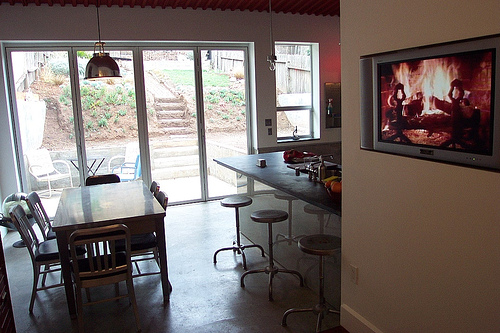

In [27]:
from PIL import Image
import IPython.display as display

# Open the image
image_path = '/home/vcl3d/coco_dataset_VOX_5000/train2014/COCO_train2014_000000001306.jpg'
img = Image.open(image_path)

# Display the image
display.display(img)

In [24]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 80
    })
    test: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 16
    })
})